# Diamond Price Analysis
---
### Authors:
* Marcin Bereźnicki
* Jakub Burczyk
---
### The problem:
The purpose of the project was to analyze diamond's pricing based on it's weight.

### The goal:
We hope, that after creating sufficient model it will be possible to predict a price for gem given it's mass in carats. 

It may be possible to estimate a price without any trade specific knowledge for example about type of cuts, which could prevent getting ripped off by sellers/buyers.

---

# Table of contents
We highly recommend using provided hyperlinks to sections.

* [Dataset](#dataset)
* [Python modules](#imports)
* [Data Tidying](#data-tidying)
  * [Dropping indexes](#dropping-index)
  * [Mass and price extraction](#mass-and-price-extraction)
  * [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting)
* [Data Analysis](#data-analysis)
  * [Loading dataset](#loading-dataset)
  * [Model 1 - 1st degree polynomial regression](#model-1---linear-regression---1st-degree)
    * [Prior predictive check](#model-1---prior-predictive-check)
    * [Posterior analysis](#model-1---posterior-analysis)
    * [Linear regression](#model-1---stan-linear-regression)
    * [Model parameters](#model-1---model-parameters)
    * [Evaluation](#model-1---evaluation)
      * [Quantiles](#model-1---quantiles)
      * [Predictions and density](#model-1---predictions-and-density-plot)
  * [Model Comparison](#model-comparison)
    * [PSIS-LOO Criterion](#psis-loo-criterion)
    * [WAIC Criterion](#waic-criterion)
    * [Conclusions](#model-comparison---conclusions)

---
# Dataset
[***Return to table of contents***](#table-of-contents)

The data was sourced from [Kaggle.com](https://www.kaggle.com/) which is an online community of data scientists. The dataset can be downloaded [**here**](https://www.kaggle.com/datasets/shivam2503/diamonds).

Dataset contains 53 941 records containing description of 10 diamond properties.

The colums are as follows:
* **price** - in US dollars
* **carat** - weight of the gem
* **cut** - quality of the cut
* **color** - gem's color
* **clarity** - measurement how clear the gem is and it's defects
* **x** - length in milimiters
* **y** - width in milimiters
* **z** - depth in milimiters
* **table** width of top face of the diamond relative to widest point
* **depth** - depth percentage 
\begin{equation}
depth = \frac{z}{mean(x,y)}
\end{equation}

---

---
# Imports
[***Return to table of contents***](#table-of-contents)


Necessary python modules for data analysis.

---

In [29]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import random as rd

#import warnings
#warnings.filterwarnings('ignore')

---
# Data tidying
[***Return to table of contents***](#table-of-contents)

Before starting analysis it is necessary to clean up the dataset.

---
## Dropping index
[***Return to table of contents***](#table-of-contents)

The first column contians record id without column name, but for our purpouses it is not necessary thus it gets dropped after loading the dataset file.

---

In [2]:
df = pd.read_csv("data/diamonds.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


---
## Data extraction
[***Return to table of contents***](#table-of-contents)

For our analysis we will consider only one variable affecting gem pricing - it's mass. For each carat value, the average diamond price is calculated.

The data gets trimmed to contain only the necessary information and saved accordingly to ```CSV``` file located at ```./output/caratPrice.csv```.

---

In [3]:
cutRemap = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
clarityRemap = {'I1': 1 , 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
colorRemap = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}

df=df.replace({"cut": cutRemap})
df=df.replace({"clarity": clarityRemap})
df=df.replace({"color": colorRemap})

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75


---
## Plotting dataset
[***Return to table of contents***](#table-of-contents)

It is important to see the data before commencing analysis, afterall we should check in case it's utter nonsense as demonstrated [**here**](https://cran.r-project.org/web/packages/datasauRus/vignettes/Datasaurus.html).

---

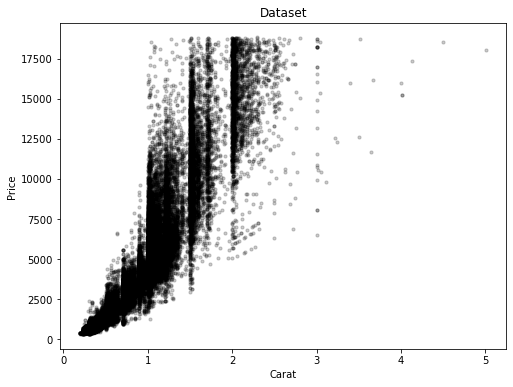

In [4]:
plt.figure(figsize=[8, 6])
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.title('Dataset')
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

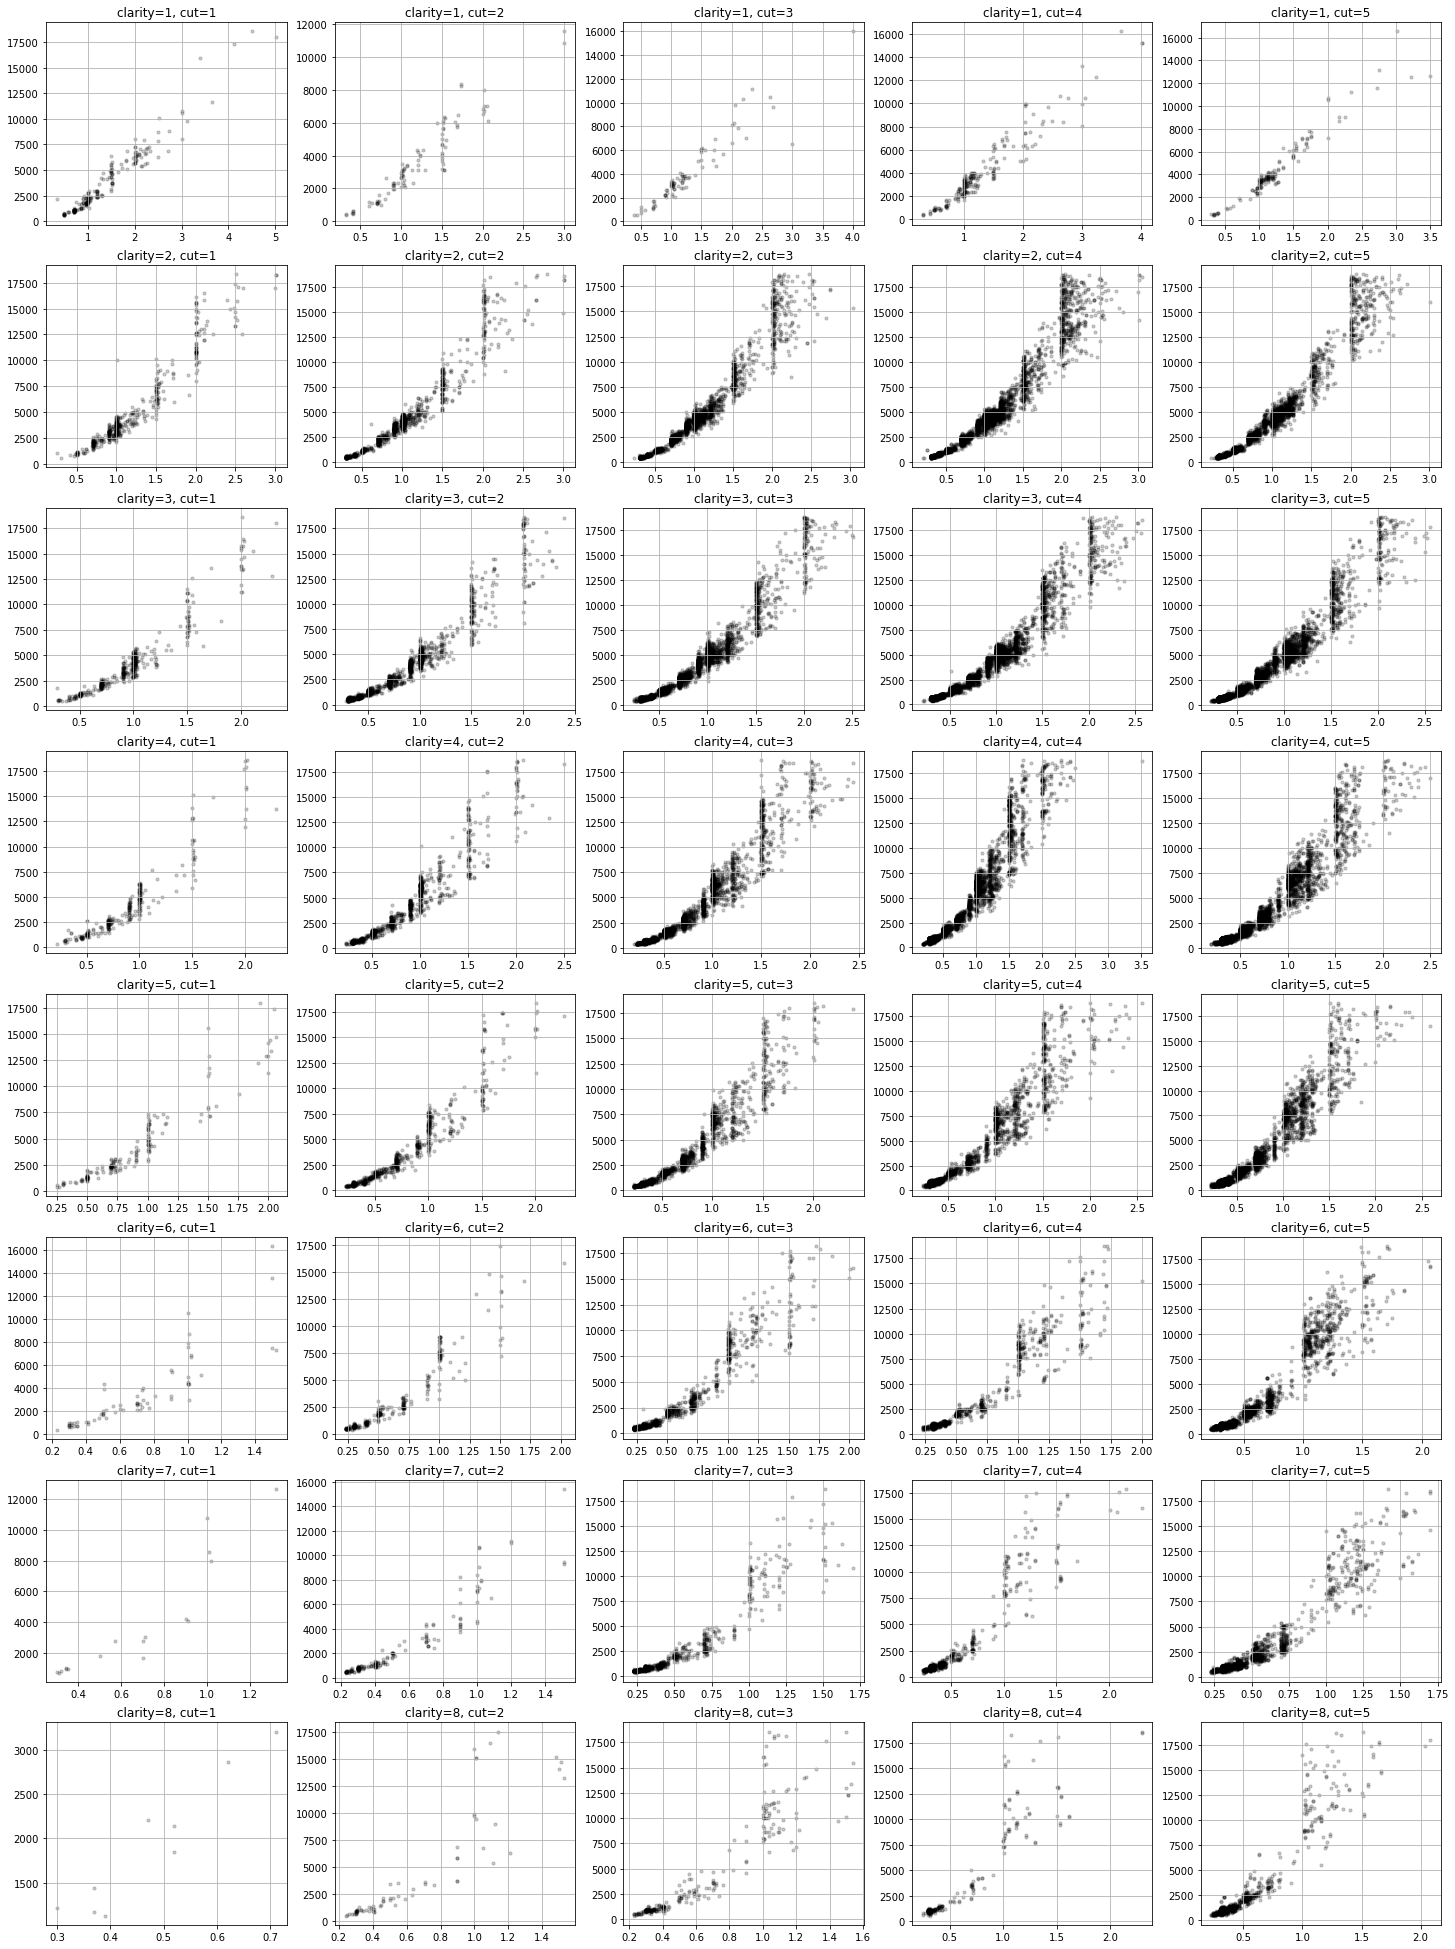

In [5]:
fig, axs = plt.subplots(8,5)
fig.set_size_inches(25, 35)
for i in range(0,8):
    for j in range(0,5):
        df_temp = df.loc[df['clarity'] == i+1]
        df_temp = df_temp.loc[df_temp['cut'] == j+1]
        axs[i][j].scatter(df_temp.carat, df_temp.price, color='black', alpha=0.2, s=10)
        axs[i][j].grid()
        axs[i][j].set_title(f'clarity={i+1}, cut={j+1}')
plt.show()

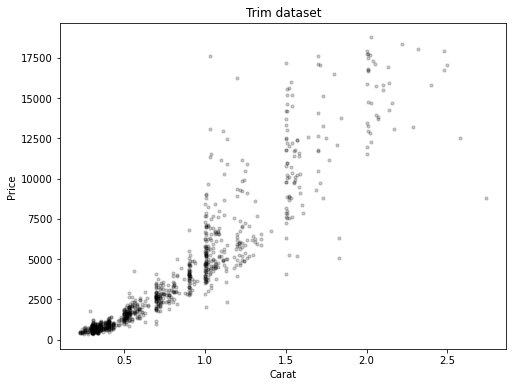

In [6]:
df_trim = df.sample(n = 1000)
df_trim.reset_index(drop=True, inplace=True)

plt.figure(figsize=[8, 6])
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.title('Trim dataset')
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

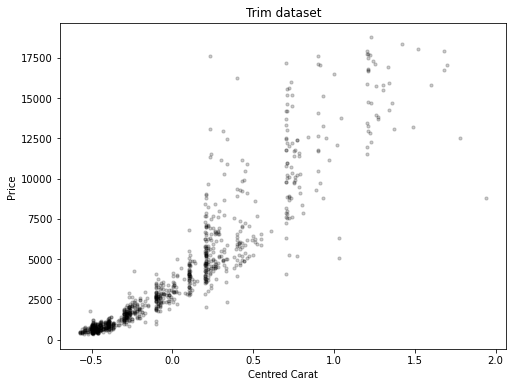

In [7]:
df_trim['c_carat'] = df_trim.carat - df_trim.carat.mean()

plt.figure(figsize=[8, 6])
plt.scatter(df_trim.c_carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.title('Trim dataset')
plt.xlabel("Centred Carat")
plt.ylabel("Price")
plt.show()

---
# Data Analysis
[***Return to table of contents***](#table-of-contents)

For analysis we have created 3 bayesian models.

* Model 1 - uses 1st degree polynomial (a linear function)
* Model 2 - 

Expanding the first model by increasing the order of the polynomial allows for a better fit of the model to the observations, in terms of the data, and for value prediction. The third model is the departure from polynomial regression to the simulating from a Gaussian Process conditional on non-Gaussian observations.

The equations, parameters and differences of individual models are presented in the corresponding chapters.

---

---
## Model 1 - 2 predictors
[***Return to table of contents***](#table-of-contents)

Our first model was based on 1st degree polynomial function.

Model has form:

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$

With parameter distributions set as follows:
$$ \alpha \sim \mathrm{Normal}(193, 5) $$
$$ \beta \sim \mathrm{Normal}(5625, 5) $$
$$ \sigma \sim \mathrm{Exponential}(5) $$

The required input data is the set of carats for which the user wants to make a prediction.

---
### Model 1 - Prior predictive check
[***Return to table of contents***](#table-of-contents)

First step is prior predicive check whether parameter values and distributions "make sense".

Parameters simulated from priors are a result of the model definition. The first order polynomial requires two parameters to equate the line, and the third is the width of the fit.

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

Priors were selected on the basis of the polynomial equation in the chapter [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting).

![](./images/model_1_ppc.png)

---

In [32]:
model_1_ppc = CmdStanModel(stan_file='stanfiles/model_1_ppc.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1_ppc.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1_ppc.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1_ppc.exe


In [33]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'cut': df_trim.clarity}
model_1_sim = model_1_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [34]:
data = model_1_sim.draws_pd()
print(data)

     lp__  accept_stat__  alpha_cut[1]  alpha_cut[2]  alpha_cut[3]  \
0     0.0            0.0      -999.286      -998.650      -998.968   
1     0.0            0.0      -987.186     -1003.150      -996.170   
2     0.0            0.0     -1017.570      -991.184     -1002.430   
3     0.0            0.0      -988.476     -1016.530     -1003.150   
4     0.0            0.0      -991.595      -983.329      -979.182   
..    ...            ...           ...           ...           ...   
995   0.0            0.0     -1007.050      -991.984     -1010.960   
996   0.0            0.0     -1007.110      -995.887      -993.814   
997   0.0            0.0     -1007.820      -992.132     -1022.770   
998   0.0            0.0      -974.287      -993.862     -1014.150   
999   0.0            0.0      -996.472      -994.419     -1008.310   

     alpha_cut[4]  alpha_cut[5]  alpha_cut[6]  alpha_cut[7]  alpha_cut[8]  \
0       -1002.690     -1016.280      -989.593      -996.421      -999.870   
1    

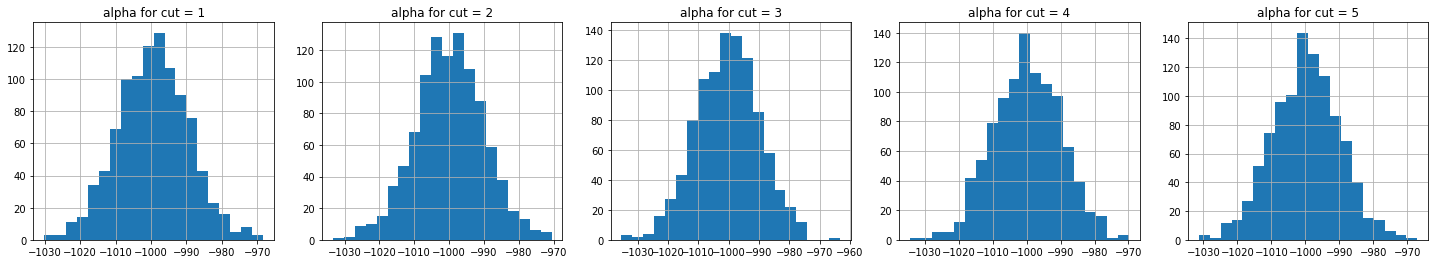

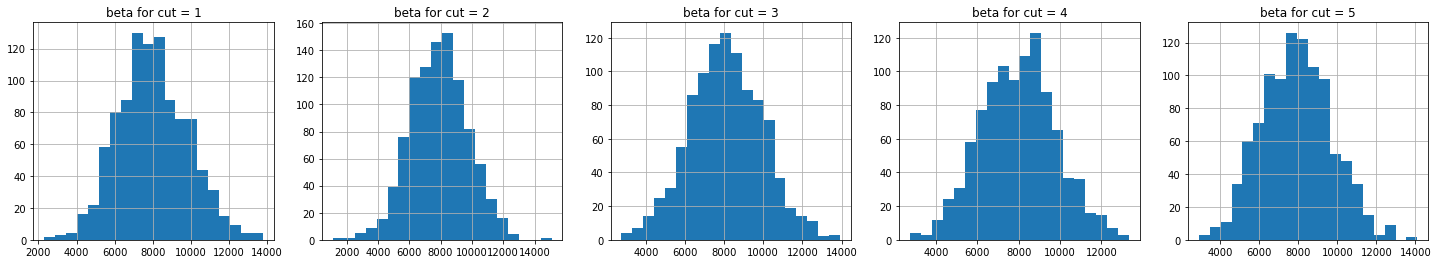

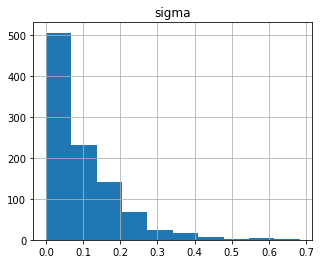

,mean,sd,hdi_3%,hdi_97%
alpha_cut[0],-999.38,10.00,-1017.91,-980.58
alpha_cut[1],-999.87,9.83,-1018.40,-981.87
alpha_cut[2],-1000.26,10.41,-1020.43,-981.08
alpha_cut[3],-999.88,9.84,-1018.00,-982.33
alpha_cut[4],-999.79,9.81,-1019.38,-983.02
alpha_cut[5],-999.83,10.24,-1018.90,-980.53
alpha_cut[6],-999.73,10.21,-1019.24,-981.66
alpha_cut[7],-999.60,10.13,-1017.34,-979.50
beta_cut[0],8009.95,1828.44,5010.57,11781.60
beta_cut[1],7896.68,1816.92,4763.35,11388.40


In [35]:
alpha_cut_sim = pd.DataFrame(model_1_sim.stan_variable('alpha_cut'))
beta_cut_sim = pd.DataFrame(model_1_sim.stan_variable('beta_cut'))
sigma_sim = model_1_sim.stan_variable('sigma')
price_sim = model_1_sim.stan_variable('price')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_cut_sim[i], bins=20)
    axs[i].set_title(f"alpha for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_cut_sim[i], bins=20)
    axs[i].set_title(f"beta for cut = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_sim)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_1_sim, var_names=['alpha_cut', 'beta_cut', 'sigma'], round_to=2, kind='stats')

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

In [36]:
def calcQuants(x, y):
    qlvls = [0, 1]
    quansList = [[], []]
    for i in range(y.shape[-1]):
        temp = y[:, i]
        for q, lvl in zip(quansList, qlvls):
            q.append(np.quantile(temp, lvl))
    #for quantile in quansList[:]:
    #    plt.scatter(x, quantile)
    #plt.legend(['min', '5%', '25%', '50%', '75%', '95%', 'max'])
    return quansList

def quantsExtremes(df, y, q):
    carat_uq = df.carat.unique()
    carat_uq = sorted(carat_uq)
    quansList = calcQuants(df.carat, y)
    caratQuantDict = dict()
    for carat_val in carat_uq:
        caratList = np.array(df.carat.tolist())
        idxs = np.where(caratList == carat_val)[0]
        qval = quansList[q][idxs[0]]
        for i in idxs:
            if q == 0 and quansList[q][i] < qval:
                qval = quansList[q][i]
            elif q == 1 and quansList[q][i] > qval:
                qval = quansList[q][i]
        if q == 0:
            caratQuantDict[carat_val] = qval
        elif q == 1:
            caratQuantDict[carat_val] = qval
    return caratQuantDict

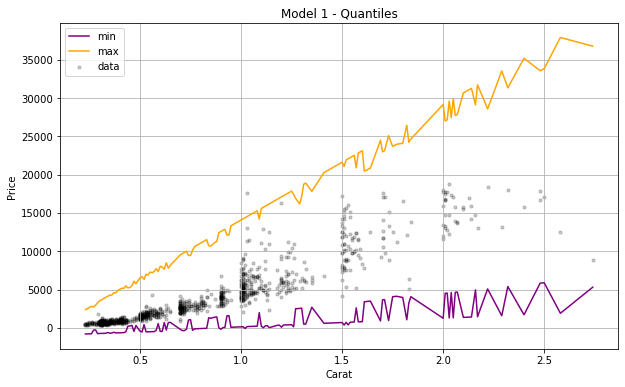

In [37]:
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

---
### Model 1 - Posterior analysis
[***Return to table of contents***](#table-of-contents)

After confirming that the priors values and trajectories are correct we can start a proper analysis.

No issues were detected during sampling.

A full model for 1st degree polynomial regression was created:

![](./images/model_lr.png)

---

In [38]:
model_1 = CmdStanModel(stan_file='stanfiles/model_1.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1.exe


In [40]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'cut': df_trim.clarity, 'price': df_trim.price}
model_1_fit = model_1.sample(data=data_sim)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


---

### Model 1 - model parameters
[***Return to table of contents***](#table-of-contents)

We can also extract stan variables that are used in the final price prediction equation.

Based on the presented graphs and histograms of parameters, it can be concluded that parameter values ​​are relatively concentrated. 

Their slight dispersion is good due to the fact that it is not possible to perfectly match the lines to observations.

---

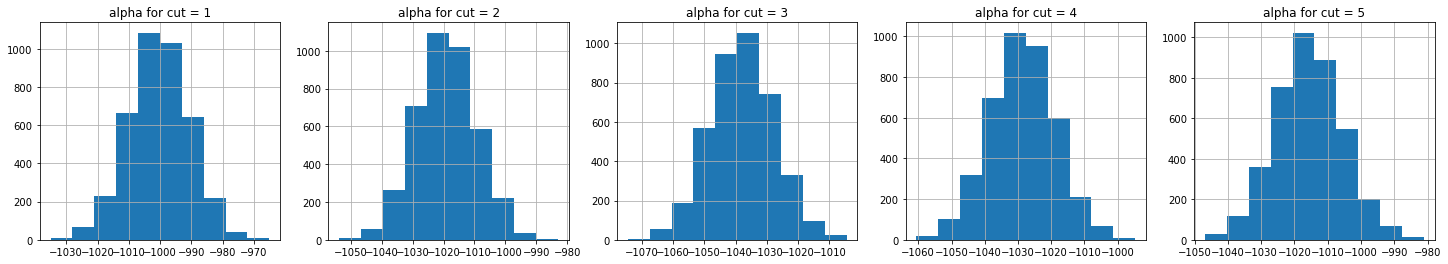

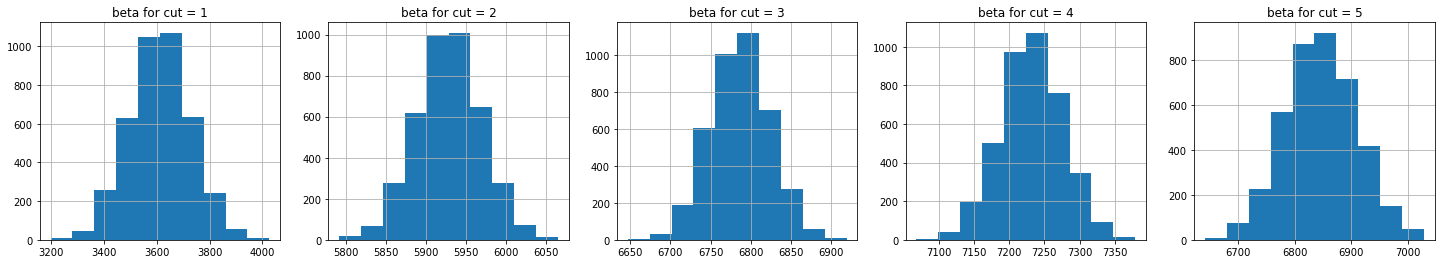

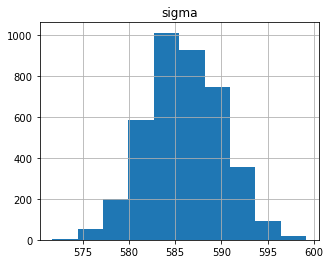

,mean,sd,hdi_3%,hdi_97%
alpha_cut[0],-1000.36,9.75,-1019.22,-982.25
alpha_cut[1],-1019.07,9.65,-1035.53,-999.94
alpha_cut[2],-1037.87,10.26,-1056.79,-1018.21
alpha_cut[3],-1028.75,9.89,-1047.16,-1010.09
alpha_cut[4],-1015.67,10.10,-1035.30,-997.21
alpha_cut[5],-1013.37,10.21,-1031.76,-994.68
alpha_cut[6],-1011.00,9.95,-1029.10,-992.30
alpha_cut[7],-1005.79,10.05,-1023.84,-985.97
beta_cut[0],3612.35,114.40,3400.02,3825.42
beta_cut[1],5928.21,40.70,5852.36,6003.93


In [41]:
alpha_cut_fit = pd.DataFrame(model_1_fit.stan_variable('alpha_cut'))
beta_cut_fit = pd.DataFrame(model_1_fit.stan_variable('beta_cut'))
sigma_fit = model_1_fit.stan_variable('sigma')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_cut_fit[i])
    axs[i].set_title(f"alpha for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_cut_fit[i])
    axs[i].set_title(f"beta for cut = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_fit)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_1_fit, var_names=['alpha_cut', 'beta_cut', 'sigma'], round_to=2, kind='stats')

---

### Model 1 - evaluation

[***Return to table of contents***](#table-of-contents)

We can now observe the results.

---

#### Model 1 - quantiles
[***Return to table of contents***](#table-of-contents)

After simulating we can analyze predictions. The quantiles follow a linear function. The right side of the plot gets squished as there are fewer diamonds of higher weights.

---

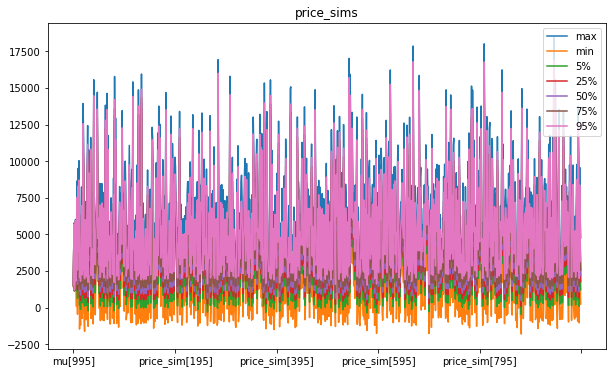

In [42]:
data = model_1_fit.draws_pd()
price_sims = data[data.columns[len(df_trim)+18:len(df_trim)+1018]]
#print(price_sims)

quans = pd.DataFrame({'max': price_sims.max(), 'min': price_sims.min(), '5%': price_sims.quantile(0.05), '25%': price_sims.quantile(0.25), '50%': price_sims.quantile(0.5), '75%': price_sims.quantile(0.75), '95%': price_sims.quantile(0.95)})
quans.plot(figsize=(10,6))
plt.title("price_sims")
plt.show()

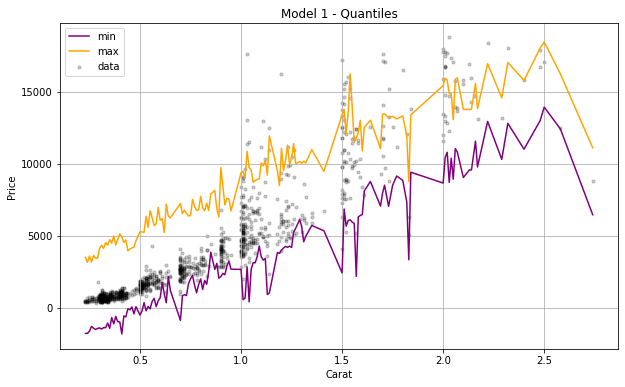

In [43]:
price_sim = model_1_fit.stan_variable('price_sim')
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

4000


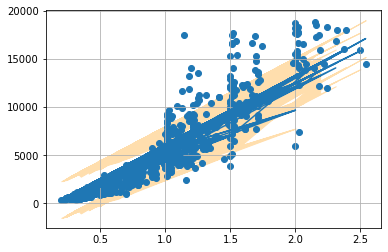

In [ ]:
x = df_trim.carat
y = price_sims.mean(axis=0)
sigma_mean = np.mean(sigma_fit)
print(len(sigma_fit))
    
plt.plot(x, y)
plt.fill_between(x, y+3*sigma_mean, y-3*sigma_mean, color='navajowhite')
plt.grid()
plt.scatter(df_trim.carat, df_trim.price)
plt.show()

---
#### Model 1 - predictions and density plot
[***Return to table of contents***](#table-of-contents)

As we can see the model is not sufficient to describe the phenomenon. 

While it's somewhat true for a narrow band of weights (about 1-1.5 carats), it is not accurate for low and med-high gems. It also gets progressively worse as true diamond prices plateau above 3 carat mark, most likely due to higher chances of defects.

The model predicted that most diamonds oscillate around value of 10 000 while the ground truth is exacly opposite, there are more low and high costs diamonds rather than the mid ones.

---

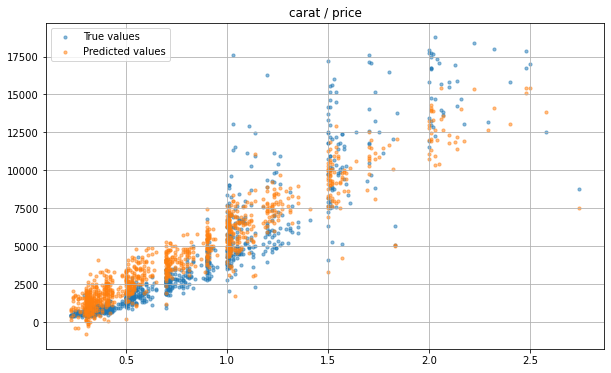

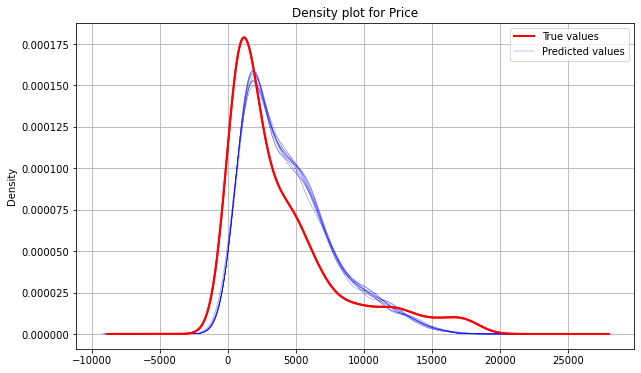

In [44]:
price_sim = model_1_fit.stan_variable('price_sim')
plt.figure(figsize=[10,6])
plt.scatter(df_trim.carat, df_trim.price, alpha=0.5, s=10)
plt.scatter(df_trim.carat, price_sim[0], alpha=0.5, s=10)
plt.title("carat / price")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

---
## Model 2 - Added 3rd predictor
[***Return to table of contents***](#table-of-contents)

Our first model was based on 1st degree polynomial function.

Model has form:

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$

With parameter distributions set as follows:
$$ \alpha \sim \mathrm{Normal}(193, 5) $$
$$ \beta \sim \mathrm{Normal}(5625, 5) $$
$$ \sigma \sim \mathrm{Exponential}(5) $$

The required input data is the set of carats for which the user wants to make a prediction.

---
### Model 2 - Prior predictive check
[***Return to table of contents***](#table-of-contents)

First step is prior predicive check whether parameter values and distributions "make sense".

Parameters simulated from priors are a result of the model definition. The first order polynomial requires two parameters to equate the line, and the third is the width of the fit.

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

Priors were selected on the basis of the polynomial equation in the chapter [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting).

![](./images/model_1_ppc.png)

---

In [45]:
model_2_ppc = CmdStanModel(stan_file='stanfiles/model_2_ppc.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_2_ppc.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_2_ppc.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_2_ppc.exe


In [46]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'cut': df_trim.cut, 'clarity': df_trim.clarity}
model_2_sim = model_2_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


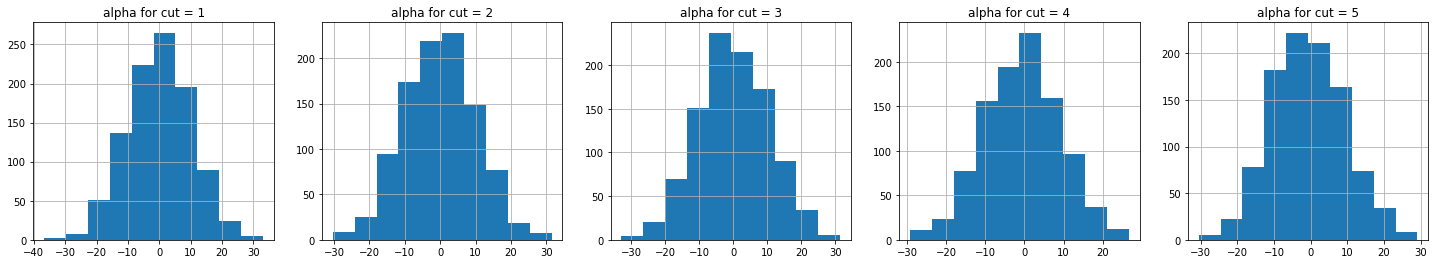

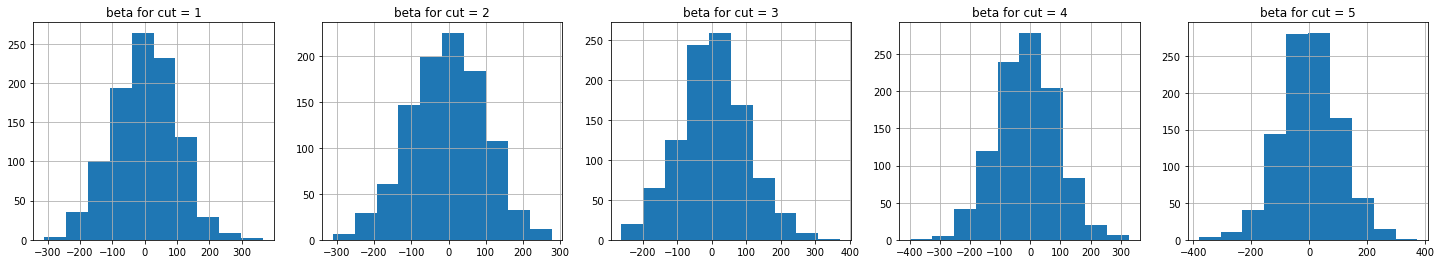

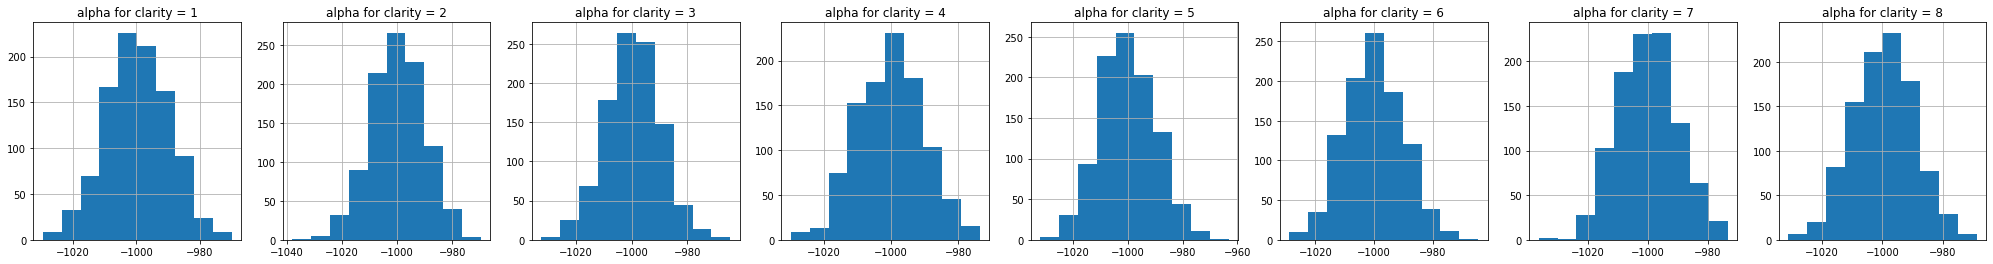

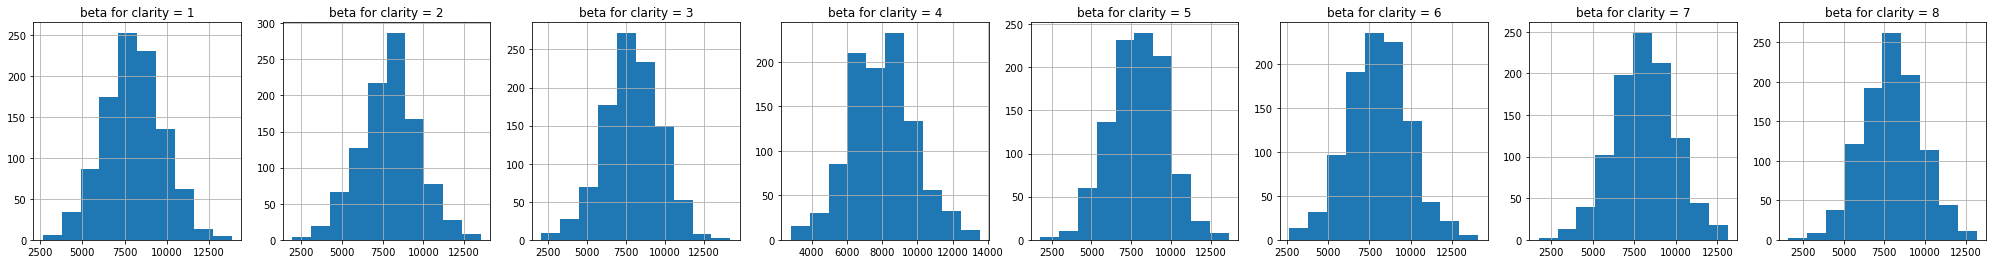

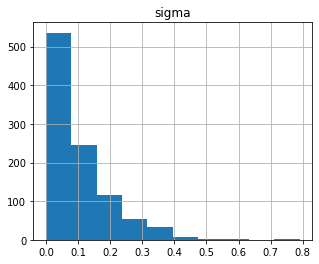

,mean,sd,hdi_3%,hdi_97%
alpha_cut[0],0.07,10.15,-18.83,18.63
alpha_cut[1],-0.15,10.11,-16.77,19.47
alpha_cut[2],0.18,10.31,-18.27,20.23
alpha_cut[3],-0.62,9.66,-17.00,18.10
alpha_cut[4],-0.67,9.84,-17.88,18.59
beta_cut[0],1.41,98.19,-198.46,159.84
beta_cut[1],-4.97,100.69,-192.32,188.09
beta_cut[2],3.49,97.83,-185.05,192.28
beta_cut[3],-11.95,101.48,-199.40,166.09
beta_cut[4],2.83,100.88,-174.41,213.06


In [47]:
alpha_cut_sim = pd.DataFrame(model_2_sim.stan_variable('alpha_cut'))
alpha_clarity_sim = pd.DataFrame(model_2_sim.stan_variable('alpha_clarity'))
beta_cut_sim = pd.DataFrame(model_2_sim.stan_variable('beta_cut'))
beta_clarity_sim = pd.DataFrame(model_2_sim.stan_variable('beta_clarity'))
sigma_sim = model_2_sim.stan_variable('sigma')
price_sim = model_2_sim.stan_variable('price')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_cut_sim[i])
    axs[i].set_title(f"alpha for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_cut_sim[i])
    axs[i].set_title(f"beta for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(alpha_clarity_sim[i])
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(beta_clarity_sim[i])
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_sim)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_2_sim, var_names=['alpha_cut', 'beta_cut', 'alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

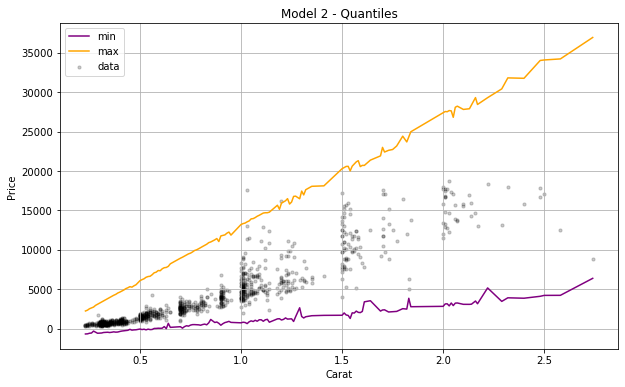

In [48]:
price_sim = model_2_sim.stan_variable('price')
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 2 - Quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

---
### Model 2 - Posterior analysis
[***Return to table of contents***](#table-of-contents)

After confirming that the priors values and trajectories are correct we can start a proper analysis.

No issues were detected during sampling.

A full model for 1st degree polynomial regression was created:

![](./images/model_lr.png)

---

In [50]:
model_2 = CmdStanModel(stan_file='stanfiles/model_2.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_2.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_2.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_2.exe


In [51]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'cut': df_trim.cut, 'clarity': df_trim.clarity, 'price': df_trim.price}
model_2_fit = model_2.sample(data=data_sim)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


---

### Model 2 - model parameters
[***Return to table of contents***](#table-of-contents)

We can also extract stan variables that are used in the final price prediction equation.

Based on the presented graphs and histograms of parameters, it can be concluded that parameter values ​​are relatively concentrated. 

Their slight dispersion is good due to the fact that it is not possible to perfectly match the lines to observations.

---

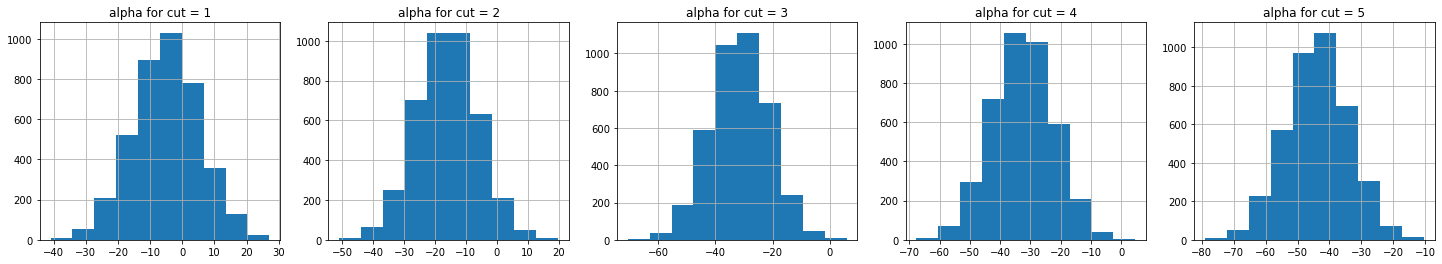

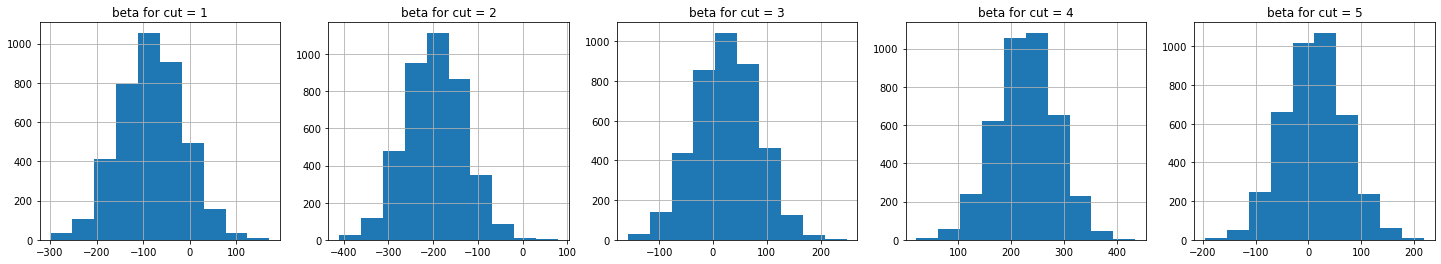

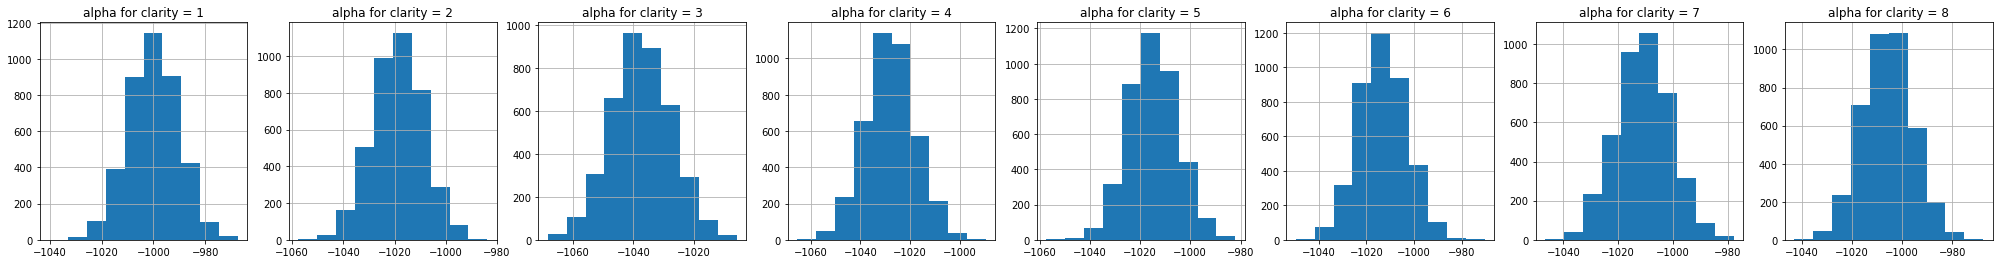

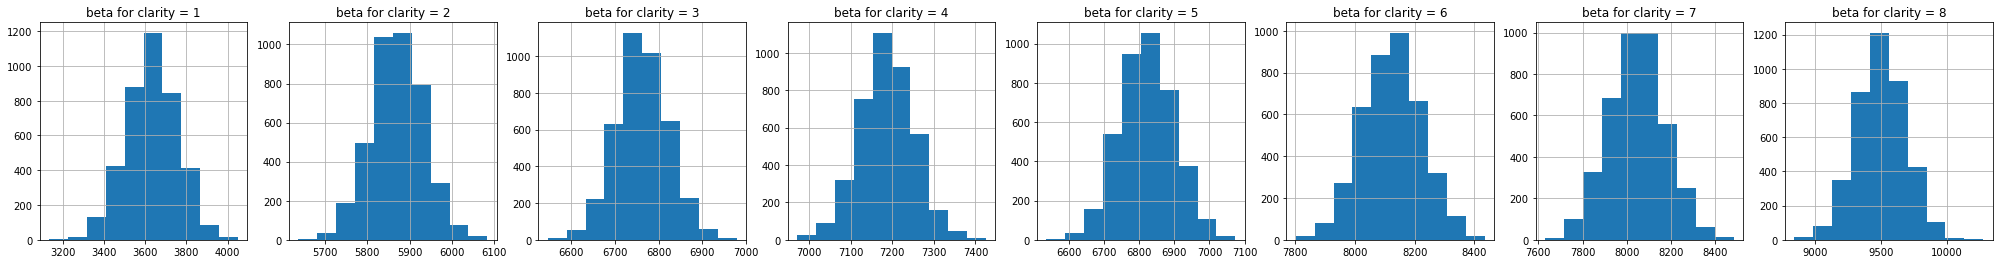

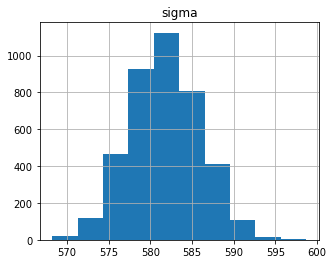

,mean,sd,hdi_3%,hdi_97%
alpha_cut[0],-5.06,10.23,-23.98,14.72
alpha_cut[1],-16.02,9.90,-34.67,1.79
alpha_cut[2],-31.50,10.19,-50.37,-12.16
alpha_cut[3],-32.53,10.08,-50.88,-13.33
alpha_cut[4],-43.78,9.94,-61.54,-24.41
beta_cut[0],-81.62,68.67,-215.26,40.99
beta_cut[1],-195.93,65.59,-311.71,-67.78
beta_cut[2],25.28,58.40,-82.72,131.88
beta_cut[3],228.32,56.75,116.86,329.61
beta_cut[4],11.48,57.91,-92.43,126.22


In [52]:
alpha_cut_fit = pd.DataFrame(model_2_fit.stan_variable('alpha_cut'))
alpha_clarity_fit = pd.DataFrame(model_2_fit.stan_variable('alpha_clarity'))
beta_cut_fit = pd.DataFrame(model_2_fit.stan_variable('beta_cut'))
beta_clarity_fit = pd.DataFrame(model_2_fit.stan_variable('beta_clarity'))
sigma_fit = model_2_fit.stan_variable('sigma')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_cut_fit[i])
    axs[i].set_title(f"alpha for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_cut_fit[i])
    axs[i].set_title(f"beta for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(alpha_clarity_fit[i])
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(beta_clarity_fit[i])
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_fit)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_2_fit, var_names=['alpha_cut', 'beta_cut', 'alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

---

### Model 2 - evaluation

[***Return to table of contents***](#table-of-contents)

We can now observe the results.

---

#### Model 2 - quantiles
[***Return to table of contents***](#table-of-contents)

After simulating we can analyze predictions. The quantiles follow a linear function. The right side of the plot gets squished as there are fewer diamonds of higher weights.

---

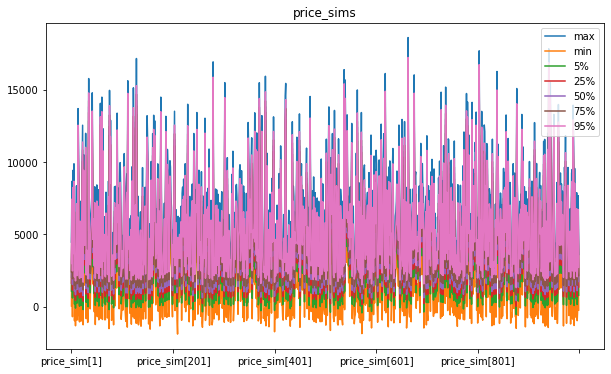

In [53]:
data = model_2_fit.draws_pd()
price_sims = data[data.columns[len(df_trim)+34:len(df_trim)+1034]]
#print(price_sims)

quans = pd.DataFrame({'max': price_sims.max(), 'min': price_sims.min(), '5%': price_sims.quantile(0.05), '25%': price_sims.quantile(0.25), '50%': price_sims.quantile(0.5), '75%': price_sims.quantile(0.75), '95%': price_sims.quantile(0.95)})
quans.plot(figsize=(10,6))
plt.title("price_sims")
plt.show()

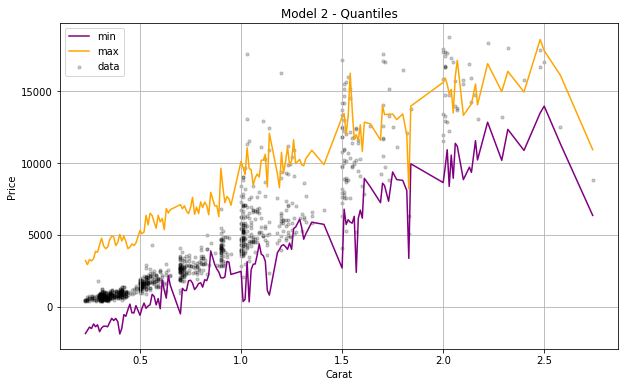

In [54]:
price_sim = model_2_fit.stan_variable('price_sim')
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 2 - Quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

---
#### Model 2 - predictions and density plot
[***Return to table of contents***](#table-of-contents)

As we can see the model is not sufficient to describe the phenomenon. 

While it's somewhat true for a narrow band of weights (about 1-1.5 carats), it is not accurate for low and med-high gems. It also gets progressively worse as true diamond prices plateau above 3 carat mark, most likely due to higher chances of defects.

The model predicted that most diamonds oscillate around value of 10 000 while the ground truth is exacly opposite, there are more low and high costs diamonds rather than the mid ones.

---

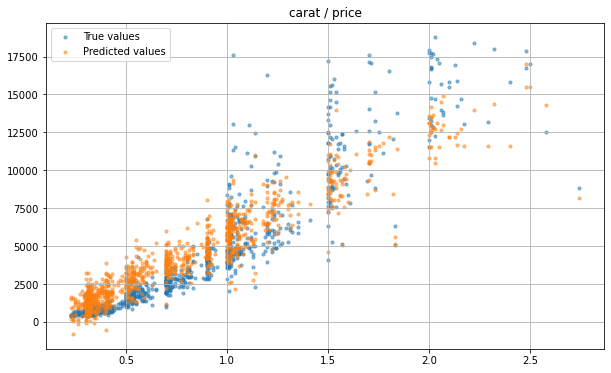

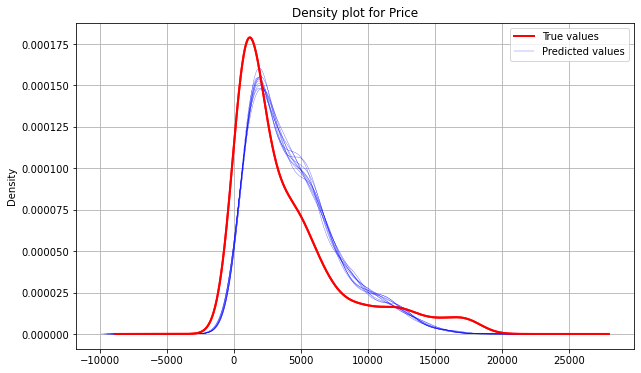

In [55]:
price_sim = model_2_fit.stan_variable('price_sim')
plt.figure(figsize=[10,6])
plt.scatter(df_trim.carat, df_trim.price, alpha=0.5, s=10)
plt.scatter(df_trim.carat, price_sim[1], alpha=0.5, s=10)
plt.title("carat / price")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()